<a href="https://colab.research.google.com/github/Eloiseedwards/Assessment-2/blob/main/finBERT_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install evaluate

In [30]:
import random, os
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
from datasets import load_dataset
ds2 = load_dataset("FinGPT/fingpt-sentiment-train", split="train")

In [33]:
mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}

In [34]:
def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

ds2 = ds2.map(map_to_5)

In [35]:
unique_new = sorted(list(set(ds2["label_5"])))
id2label = {i: lab for i, lab in enumerate(unique_new)}
label2id = {lab: i for i, lab in id2label.items()}

def encode_label(example):
    example["label"] = label2id[example["label_5"]]
    return example

ds2 = ds2.map(encode_label)

In [36]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
def tokenize(batch):
    return tokenizer(batch["input"], truncation=True, padding="max_length", max_length=128)

ds2 = ds2.map(tokenize, batched=True)
ds2 = ds2.train_test_split(test_size=0.2)   # create validation set

ds2 = ds2.remove_columns(["output", "label_5", "input"])  # keep only tokenized fields + label
ds2.set_format("torch")

In [38]:
from transformers import TrainerCallback
import numpy as np

class TrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None  # Will be set after Trainer initialization

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            # This case should ideally not be reached if setup correctly
            raise ValueError("Trainer instance not set in TrainAccuracyCallback.")

        train_ds = self.trainer.train_dataset

        # Get predictions on the training set
        preds_output = self.trainer.predict(train_ds, metric_key_prefix="train")
        logits = preds_output.predictions
        labels = preds_output.label_ids
        preds = np.argmax(logits, axis=1)

        # Compute accuracy
        train_acc = (preds == labels).mean()

        # Log accuracy into trainer history
        self.trainer.state.log_history.append({
            "epoch": state.epoch,
            "train_accuracy": train_acc,
            "step": state.global_step
        })

        print(f"Training Accuracy (epoch {state.epoch:.0f}): {train_acc:.4f}")

In [39]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch, numpy as np
from evaluate import load


metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}

# --------------------------------
# Freeze more layers (10 instead of 8)
# --------------------------------
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# --------------------------------
# Increase dropout aggressively
# --------------------------------
model.bert.config.hidden_dropout_prob = 0.2
model.bert.config.attention_probs_dropout_prob = 0.2

# --------------------------------
# Training settings to reduce overfitting
# --------------------------------
args = TrainingArguments(
    output_dir="./finbert_newmodel",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=8e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.05,
    warmup_ratio=0.2,
    fp16=True,
    report_to="none",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    max_grad_norm=1.0,
    seed=42,
    data_seed=42
)

train_acc_callback = TrainAccuracyCallback() # Instantiate the callback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2), train_acc_callback] # Add the custom callback here
)

train_acc_callback.trainer = trainer # Set the trainer instance

trainer.train()

/tmp/ipython-input-2860797683.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.584000,0.399012,0.865842
2,0.308200,0.260863,0.913188
3,0.222000,0.234841,0.923543
4,0.191400,0.220174,0.928883
5,0.172200,0.221464,0.930316


Training Accuracy (epoch 1): 0.8746
Training Accuracy (epoch 2): 0.9329
Training Accuracy (epoch 3): 0.9492
Training Accuracy (epoch 4): 0.9582
Training Accuracy (epoch 5): 0.9605


TrainOutput(global_step=9600, training_loss=0.3543204436699549, metrics={'train_runtime': 2242.1622, 'train_samples_per_second': 136.959, 'train_steps_per_second': 4.282, 'total_flos': 2.019990869463936e+16, 'train_loss': 0.3543204436699549, 'epoch': 5.0})

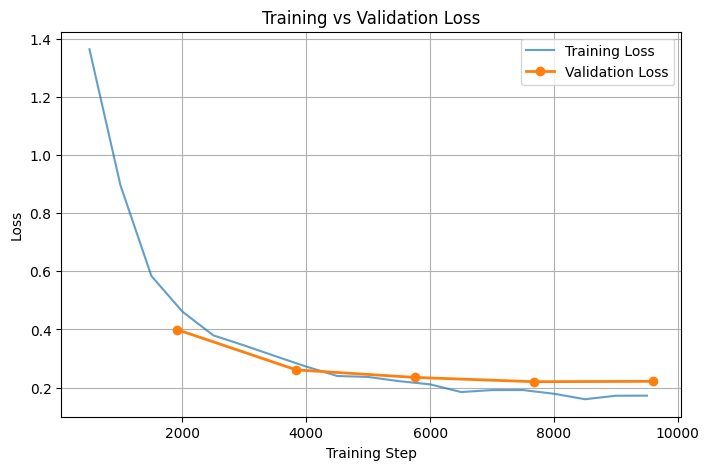

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Load logs
logs = pd.DataFrame(trainer.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

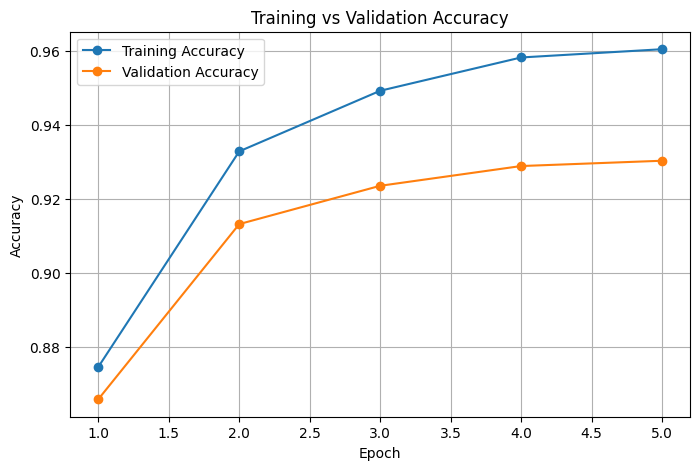

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Check if 'train_accuracy' exists before processing
if "train_accuracy" in logs.columns:
    train_acc = logs.dropna(subset=["train_accuracy"])
else:
    train_acc = pd.DataFrame()
    print("Warning: 'train_accuracy' column not found in logs. Training accuracy plot will be skipped.")

# Check if 'eval_accuracy' exists before processing
# The Trainer should log 'eval_accuracy' if compute_metrics is provided.
if "eval_accuracy" in logs.columns:
    eval_acc = logs.dropna(subset=["eval_accuracy"])
else:
    eval_acc = pd.DataFrame()
    print("Warning: 'eval_accuracy' column not found in logs. Validation accuracy plot will be skipped.")


plt.figure(figsize=(8,5))
plotted_anything = False

if not train_acc.empty:
    plt.plot(train_acc["epoch"], train_acc["train_accuracy"], marker="o", label="Training Accuracy")
    plotted_anything = True

if not eval_acc.empty:
    plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], marker="o", label="Validation Accuracy")
    plotted_anything = True

if plotted_anything:
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No accuracy data available to plot after training.")

In [42]:
preds = trainer.predict(ds2["test"])
pred_labels = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(preds.label_ids, pred_labels, target_names=list(id2label.values())))

                   precision    recall  f1-score   support

moderate_negative       0.79      0.79      0.79       962
moderate_positive       0.78      0.85      0.81      1729
         negative       0.97      0.95      0.96      2432
          neutral       0.95      0.94      0.94      5880
         positive       0.97      0.97      0.97      4352

         accuracy                           0.93     15355
        macro avg       0.89      0.90      0.89     15355
     weighted avg       0.93      0.93      0.93     15355



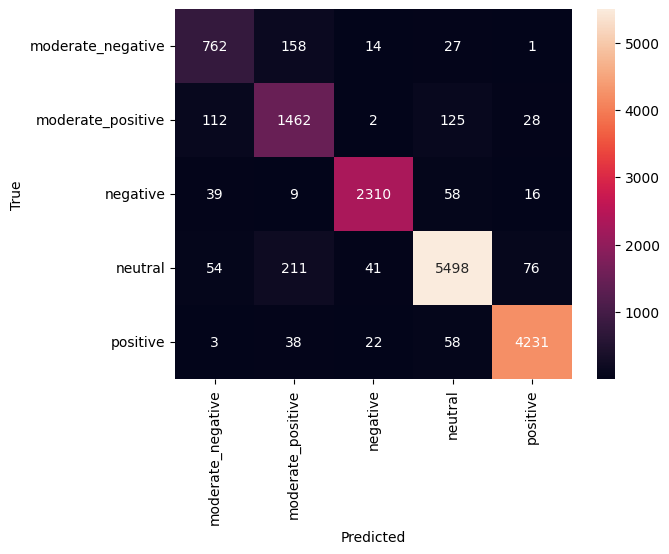

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(preds.label_ids, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [44]:
trainer.save_model("/content/drive/MyDrive/finbert_5class_model_v3")
tokenizer.save_pretrained("/content/drive/MyDrive/finbert_5class_model_v3")

('/content/drive/MyDrive/finbert_5class_model_v3/tokenizer_config.json',
 '/content/drive/MyDrive/finbert_5class_model_v3/special_tokens_map.json',
 '/content/drive/MyDrive/finbert_5class_model_v3/vocab.txt',
 '/content/drive/MyDrive/finbert_5class_model_v3/added_tokens.json',
 '/content/drive/MyDrive/finbert_5class_model_v3/tokenizer.json')